# Desarrollo del tercer proyecto de bases de datos II: Big Data & Spark

## Requerimientos Previos

Para replicar los experimentos acá tratados se debe contar con los siguientes programas y requisitos:

    - Sistema Operativo Linux
    - Python3
    - Jupyter 
    - PySpark
    - Scale
    - Java (JDK)
    - Openpyxl

## Imports

Para el desarrollo de este proyecto se hará uso de las librerías pandas como auxliar y el framework Spark por lo tanto hacemos los imports y variables de configuracion globales

In [1]:
import pandas as pd
import pyspark
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt

In [157]:
from pyspark.sql import SparkSession, Row, dataframe
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [3]:
import findspark
SPARK_PATH = '/home/bryan/spark'
findspark.init(SPARK_PATH)

POSTGRESQL_URL = "jdbc:postgresql://localhost/"
POSTGRESQL_USER = "postgres"
POSTGRESQL_PASSWORD = "root"

## Conexión con Spark

Se construye el metodo que nos permite hacer conexión con Spark, no recibe pero retorna un objeto de tipo SparkSession el cual usaremos para trabajar con Spark

In [4]:
def sparkSession():
    """
    This function builds a Spark Session
    return the main entry of a Spark DataFrame
    """
    spark = SparkSession \
      .builder \
      .appName("Test") \
      .config("spark.driver.extraClassPath", "postgresql-42.1.4.jar") \
      .config("spark.executor.extraClassPath", "postgresql-42.1.4.jar") \
      .getOrCreate()
    return spark

In [5]:
spark = sparkSession()#Definimos el objeto Spark

In [6]:
print(spark) #Si imprime bien, la conexion es exitosa

## Obtencion de los datos y conversión a DataFrame de Spark

Por medio de pandas se contacta a los archivos con los datos, y despues creamos los datas frames con Spark

In [7]:
df = pd.read_excel('Estadisticas.xlsx', engine='openpyxl') #Se lee el xlsx con pandas
oijEstadistics = spark.createDataFrame(df) #Se convierte a dataFrame

#Se define une esquema para decirle a Spark como debe leer los datos del xlsx
mySchema = StructType([StructField("Distrito", StringType(), True)\
                      ,StructField("Poblacion", StringType(), True)\
                      ,StructField("TasaParticipacion", StringType(), True)\
                      ,StructField("TasaOcupacion", StringType(), True)\
                      ,StructField("TasaDesempleo", StringType(), True)\
                      ,StructField("PorcentajeEconomicamenteInactiva", DoubleType(), True)\
                      ,StructField("RelacionDependenciaEconomica", DoubleType(), True)\
                      ,StructField("SectorPrimario", StringType(), True)\
                      ,StructField("SectorSecundario", StringType(), True)\
                      ,StructField("SectorTerciario", StringType(), True)])

df = pd.read_excel('INECEstadisticas.xlsx', engine='openpyxl') #Se lee el xlsx con pandas
inecEstadistics = spark.createDataFrame(df,schema=mySchema)#Se convierte a dataFrame


Como prueba de la obtención de los datos mostramos el estados de los dataFrames

In [8]:
oijEstadistics.show()
inecEstadistics.show()

+------+-----------+----------+-------------------+-----------+--------------------+-------------+------+------------+----------+------------+----------------+
|Delito|  SubDelito|     Fecha|               Hora|    Victima|          SubVictima|         Edad|Genero|Nacionalidad| Provincia|      Canton|        Distrito|
+------+-----------+----------+-------------------+-----------+--------------------+-------------+------+------------+----------+------------+----------------+
|ASALTO|ARMA BLANCA|2021-01-03|06:00:00 - 08:59:59|EDIFICACION|PANADERIA [EDIFIC...|Mayor de edad| MUJER|  COSTA RICA|  ALAJUELA|       UPALA|         BIJAGUA|
|ASALTO|ARMA BLANCA|2021-01-02|06:00:00 - 08:59:59|   VIVIENDA|NO APLICA [VIVIENDA]|Mayor de edad| MUJER|  COSTA RICA|     LIMON|       LIMON|          MATAMA|
|ASALTO|ARMA BLANCA|2021-01-07|12:00:00 - 14:59:59|    PERSONA|    PEATON [PERSONA]|Mayor de edad| MUJER|  COSTA RICA|  SAN JOSE|    SAN JOSE|        HOSPITAL|
|ASALTO|ARMA BLANCA|2021-01-08|03:00:00 

## Integración de los datos

Antes de poder realizar la integración se debe hacer un procesamiento de los datos de forma que al unir ambos, sea mucho más sencillo

### Eliminar espacios en blanco

Si revisamos los datos del INEC asociados a este programa veremos que se genera archivos de tipo nulo, entonces crearemos una función que se encargue de eliminarlos, recibirá el dataframe a actualizar y le filtrá, si en la columna Distrito hay un nulo, le eliminará

In [9]:
def deleteBlankSpaces(df):
    ndf = df.select('Distrito','Poblacion','TasaParticipacion','TasaOcupacion','TasaDesempleo',
                   'PorcentajeEconomicamenteInactiva','RelacionDependenciaEconomica', 'SectorPrimario', 'SectorSecundario',
                   'SectorTerciario').filter(df.Distrito != "NaN")
    return ndf

In [10]:
inecEstadistics = deleteBlankSpaces(inecEstadistics) #Solo se hace para la del INEC, debido a que el OIJ no tiene nuls
inecEstadistics.show(20)

+--------------------+---------+-----------------+----------------+----------------+--------------------------------+----------------------------+-----------------+----------------+----------------+
|            Distrito|Poblacion|TasaParticipacion|   TasaOcupacion|   TasaDesempleo|PorcentajeEconomicamenteInactiva|RelacionDependenciaEconomica|   SectorPrimario|SectorSecundario| SectorTerciario|
+--------------------+---------+-----------------+----------------+----------------+--------------------------------+----------------------------+-----------------+----------------+----------------+
|         Costa Rica |3233882.0|  53.479687879768|51.6602646602443|3.40208271898327|                 46.520312120232|             1.4873007337508| 13.8558940568599|17.8987951864923|68.2453107566478|
|            San José|1087315.0| 56.0236913865807| 54.076325627808|3.47596831014817|                43.9763086134193|            1.30523315943095| 5.46974386883908|17.2941256505323|77.2361304806286|
|    

Como se ve, los espacios blancos han sido eliminados

### Convertir a minusculas

Como motivo de aseguarnos que los registros de amhas fuentes de datos coincidan, lo mejor es manejar un estandar por lo que se buscará crear una funcion que recibe el dataframe y la eleccion que se desea cambiar y retornará un Data Frame actualizado o -1 en caso de error

In [11]:
def toMinus(df, choice):
    ndf = -1
    if choice == 1:
        ndf = inecEstadistics.select(lower(col('Distrito')).alias('Distrito'),'Poblacion','TasaParticipacion','TasaOcupacion','TasaDesempleo',
                   'PorcentajeEconomicamenteInactiva','RelacionDependenciaEconomica', 'SectorPrimario', 'SectorSecundario',
                   'SectorTerciario')
    elif choice == 2:
        ndf = oijEstadistics.select('Delito','SubDelito','Fecha','Hora'
                      ,'Victima','SubVictima','Edad'
                      ,'Genero','Nacionalidad','Provincia'
                      ,'Canton',lower(col('Distrito')).alias('Distrito'))
    return ndf

In [12]:
inecEstadistics = toMinus(inecEstadistics, 1)
oijEstadistics = toMinus(oijEstadistics,2)

inecEstadistics.show()
oijEstadistics.show()

+--------------------+---------+-----------------+----------------+----------------+--------------------------------+----------------------------+-----------------+----------------+----------------+
|            Distrito|Poblacion|TasaParticipacion|   TasaOcupacion|   TasaDesempleo|PorcentajeEconomicamenteInactiva|RelacionDependenciaEconomica|   SectorPrimario|SectorSecundario| SectorTerciario|
+--------------------+---------+-----------------+----------------+----------------+--------------------------------+----------------------------+-----------------+----------------+----------------+
|         costa rica |3233882.0|  53.479687879768|51.6602646602443|3.40208271898327|                 46.520312120232|             1.4873007337508| 13.8558940568599|17.8987951864923|68.2453107566478|
|            san josé|1087315.0| 56.0236913865807| 54.076325627808|3.47596831014817|                43.9763086134193|            1.30523315943095| 5.46974386883908|17.2941256505323|77.2361304806286|
|    

Como se puede apreciar, en ambos DataFrames ya no tenemos mayusculas en la columna distrito

### Listas sin coincidencias

Continuando con el proceso de buscar crear eficiencia para unir nuestras fuentes, crearemos una funcion que dependiendo de los Data Frames pasados por parametros genere una lista con los distritos del primero que NO estén en el segundo, y al final retornaremos una tupla con dos listas una que contiene los registros repetidos y otra que no, esto con el fin que comparar sea más sencillo

In [13]:
def getNoDuplicateDistrits(dt1, dt2):
    distritsDt1 = [x["Distrito"] for x in dt1.rdd.collect()] #Obtendremos todos los registros de la columna Distrito
    distritsDt2 = [x["Distrito"] for x in dt2.rdd.collect()]
    finalDistrits = []
    for i in distritsDt1:
        if not i in distritsDt2:
            finalDistrits.append(i)
    withoutDuplicates = []
    for i in finalDistrits:
        if not i in withoutDuplicates:
            withoutDuplicates.append(i)
    return (finalDistrits, withoutDuplicates)

In [14]:
finalDistrits = getNoDuplicateDistrits(oijEstadistics, inecEstadistics)[0]
finalDistritsWithoutDuplicates = getNoDuplicateDistrits(oijEstadistics, inecEstadistics)[1]
print(finalDistritsWithoutDuplicates)
print("\n \n \n \n Si vemos el problema radica en que hay demasiados espacios \n \n ")

print([x["Distrito"] for x in inecEstadistics.rdd.collect()])

['bijagua', 'matama', 'hospital', 'rio jimenez', 'san sebastian', 'drake', 'guaycara', 'cairo', 'pavas', 'filadelfia', 'catedral', 'san francisco', 'san rafael abajo', 'cobano', 'fortuna', 'hatillo', 'sanchez', 'chacarita', 'el roble', 'ipis', 'sabalito', 'san pedro', 'horquetas', 'llanos de santa lucia', 'merced', 'quesada', 'zapote', 'san francisco de dos rios', 'concepcion', 'tres rios', 'san felipe', 'limon', 'sabanilla', 'daniel flores', 'calle blancos', 'el tejar', 'cahuita', 'bratsi', 'san antonio', 'ulloa', 'batan', 'desconocido', 'puerto viejo', 'carmen', 'leon xiii', 'san juan', 'san jose', 'occidental', 'tacares', 'guacima', 'oriental', 'gravilias', 'barranca', 'rio segundo', 'quepos', 'cariari', 'orosi', 'jimenez', 'venecia', 'san juan de dios', 'santo tomas', 'roxana', 'aserri', 'guapiles', 'guadalupe', 'carrillos', 'san rafael arriba', 'purral', 'corredor', 'mata redonda', 'cinco esquinas', 'san miguel', 'samara', 'bejuco', 'san ramon', 'nosara', 'cutris', 'caldera', 'can

Como se puede apreciar, muchos de estos registros existen dentro de la base del Inec sin embargo, un problema de extraccion de datos genera que los strings, no sean iguales por lo que tendremos que arreglar eso, sin embargo primero crearemos una funcion que nos permita obtener el largo de estás

### Cantidad sin coincidencias

Debido a que en el paso pasado creamos una funcion que obtiene esos registros solo basta devolver el largo de estos, tambien devolveremos sin repetidos por ellos usamos una tupla

In [15]:
def getNoDuplicateDistritsLen():
    finalDistrits = getNoDuplicateDistrits(oijEstadistics, inecEstadistics)[0]
    finalDistritsWithoutDuplicates = getNoDuplicateDistrits(oijEstadistics, inecEstadistics)[1]
    return (len(finalDistrits),len(finalDistritsWithoutDuplicates))
    

In [16]:
finalDistritsLen = getNoDuplicateDistritsLen()[0]
finalDistritsWithoutDuplicatesLen = getNoDuplicateDistritsLen()[1]

print("Todos los distritos: ",finalDistritsLen)
print("Todos los distritos sin replicas: ",finalDistritsWithoutDuplicatesLen)

Todos los distritos:  13445
Todos los distritos sin replicas:  330


Y listo ahora procederemos a arreglar el error en la extracción para poder obtener los datos de manera correcta

### Arreglar problema en la extracción de los datos

Debido a los espacios en la columna distrito de los datos del INEC a la hora de realizar nuestro asocie vemos que ingnora gran parte de este para poder solucionar este error, lo que debemos hacer es crear una funcion que reciba el dataframe a arreglar y retorne el dataframe arreglado, y será tan sencillo como ejecutar un trim

In [17]:
def fixStrings(dt):
        dt = dt.withColumn('Distrito', trim(inecEstadistics.Distrito)) #Le realizamos un trim a la comlumna distrito
        return dt
inecEstadistics = fixStrings(inecEstadistics)

finalDistrits = getNoDuplicateDistrits(oijEstadistics, inecEstadistics)[0]
finalDistritsWithoutDuplicates = getNoDuplicateDistrits(oijEstadistics, inecEstadistics)[1]

finalDistritsLen = getNoDuplicateDistritsLen()[0]
finalDistritsWithoutDuplicatesLen = getNoDuplicateDistritsLen()[1]

print("Todos los distritos: ",finalDistritsLen)
print("Todos los distritos sin replicas: ",finalDistritsWithoutDuplicatesLen)

Todos los distritos:  4556
Todos los distritos sin replicas:  117


Como se puede apreciar hemos arreglado el problema pues se ha reducido el numero de manera significativa

## Migrar a Postgres

Gracias a la facilidad con que trabaja Spark solo debemos utilizar una funcion para hacer la exportacion a postgres solo mandandole el DataFrame y el nombre de la tabla como parametro

In [18]:
#Salvar datos a PostgreSQL
def write_spark_df_to_db(spark_df, table_name):
    """
    This function writes Spark dataframe to DB
    """
    spark_df \
        .write \
        .format("jdbc") \
        .mode('overwrite') \
        .option("url", POSTGRESQL_URL) \
        .option("user", POSTGRESQL_USER) \
        .option("password", POSTGRESQL_PASSWORD) \
        .option("dbtable", table_name) \
        .save()
    
write_spark_df_to_db(inecEstadistics.select("*"), "EstadisticasINEC")#Ejecutamos la funcion
write_spark_df_to_db(oijEstadistics.select("*"), "EstadisticasOIJ")

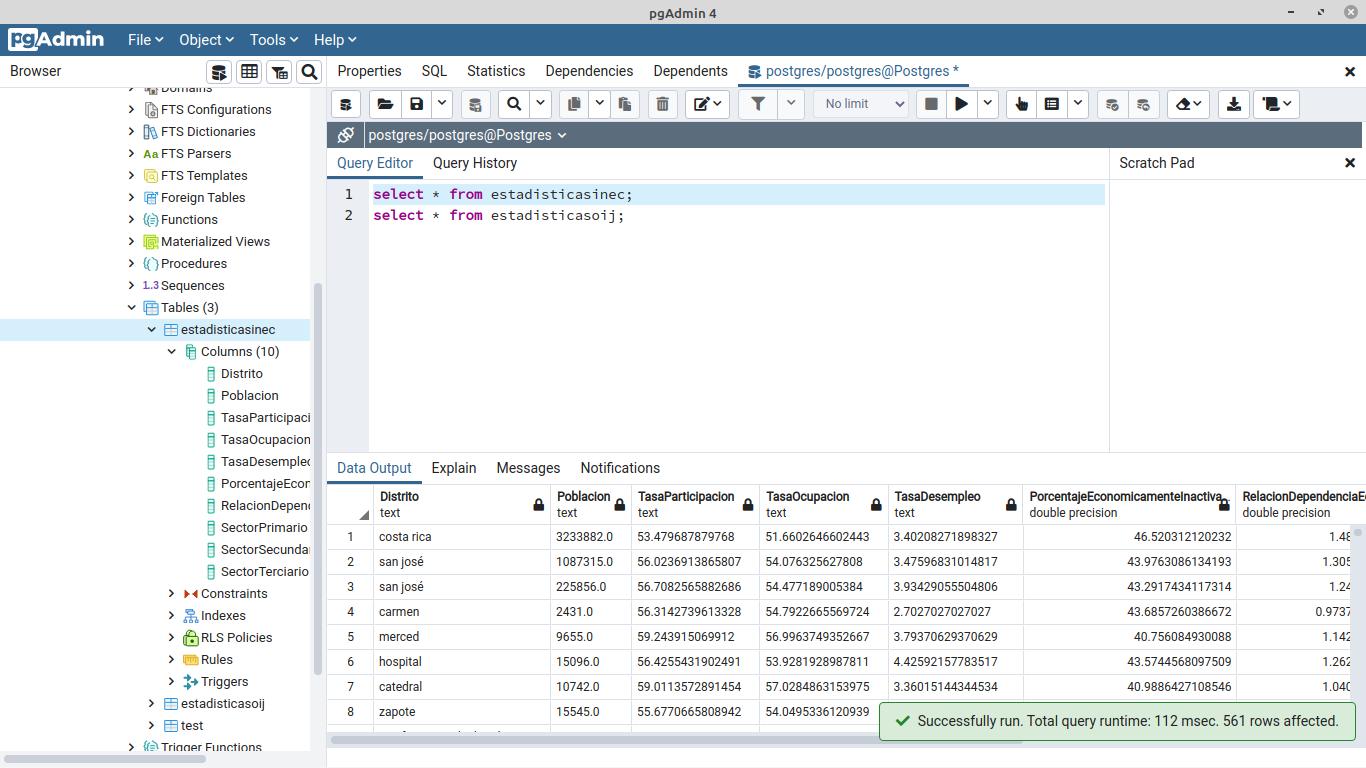 Podemos ver que los datos del INEC fueron guardados correctamente

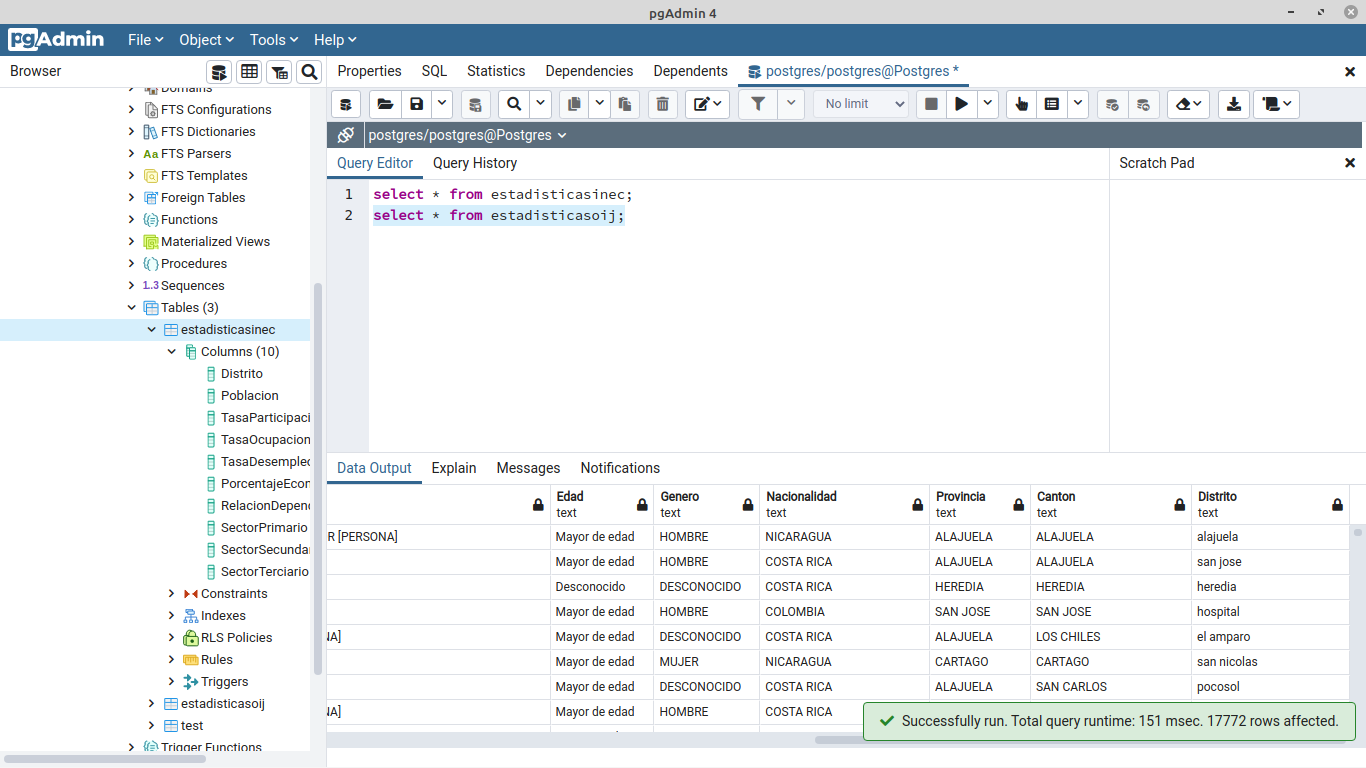 Podemos ver que los datos del OIJ fueron guardados correctamente

## Graficación

 Visualización de datos. La visualización se realizará por medio del software
Spark.

### 1. Compare la cantidad de delitos y la tasa de ocupación para los 10 distritos con más delitos en el país.

Primero se debe hacer un Joind de ambas tablas, pero para que sea más sencillo se crea una tabla consultando los 10 Distritos con más delitos y despues haremos un left join, y con plt crearemos la grafica

<AxesSubplot:title={'center':'Cantidad de delitos y la tasa de ocupación'}, xlabel='Distrito'>

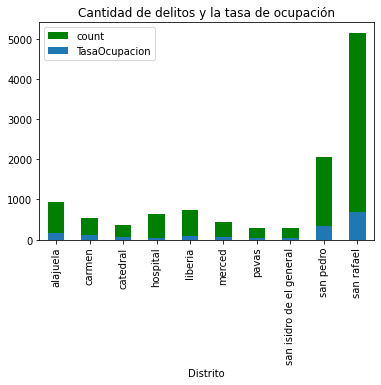

In [231]:
moreCrimesDistrit = oijEstadistics.groupBy("Distrito").count().orderBy(desc("count")).limit(10) #10 Distritos con más delitos
union = moreCrimesDistrit.join(inecEstadistics, ['Distrito'],'left')#Left join
graphic = union.toPandas()#Se convierte a pandas
graphic['TasaOcupacion'] = graphic['TasaOcupacion'].astype(float)#Que lea la tasa de ocupacion como un float
graphic.groupby('Distrito')['count'].sum().plot(kind='bar',legend=reverse, color="g",title="Cantidad de delitos y la tasa de ocupación")#Graficamos delitos
graphic.groupby('Distrito')['TasaOcupacion'].sum().plot(kind='bar',legend=reverse)#Graficamos tasa de ocupacion

### 2. Grafique la cantidad de delitos por día de la semana para el distrito con más delitos.

DISTRITO CON MÁS DELITOS hospital


<AxesSubplot:title={'center':'Cantidad de delitos por día de la semana para el distrito con más delitos.'}, xlabel='Día'>

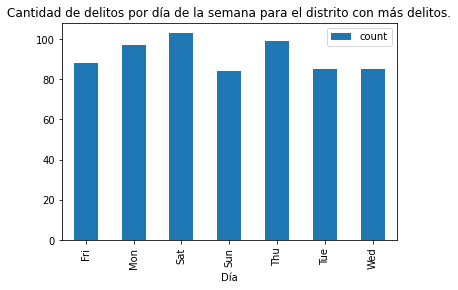

In [233]:
moreCrimesDistrit = oijEstadistics.groupBy("Distrito").count().orderBy(desc("count")).first()
allCrimesByDay = oijEstadistics.groupBy("Distrito","Delito",date_format(to_date(oijEstadistics.Fecha), 'E').alias("Día")).count().orderBy(desc("count"))
crimesByDay = allCrimesByDay.filter(allCrimesByDay.Distrito == moreCrimesDistrit[0])
graphic = crimesByDay.toPandas()
print("DISTRITO CON MÁS DELITOS",moreCrimesDistrit[0])
graphic.groupby('Día')['count'].sum().plot(kind='bar',legend=reverse,title="Cantidad de delitos por día de la semana para el distrito con más delitos.")


### 3. Grafique la cantidad de delitos por tipo y por distrito. Es decir, para el distrito seleccionado se debe graficar la cantidad de delitos por tipo

<AxesSubplot:title={'center':'Cantidad de delitos por tipo y por distrito'}, xlabel='Delito'>

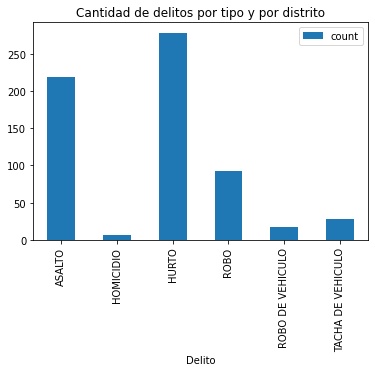

In [234]:
moreCrimesDistrit = oijEstadistics.groupBy("Distrito").count().orderBy(desc("count")).first()
allCrimesByDistric=oijEstadistics.groupBy("Distrito","Delito").count().orderBy(desc("count"))
typeOfCrime = allCrimesByDistric.filter(allCrimesByDistric.Distrito == moreCrimesDistrit[0]) # "Acá graficamos la que más nos gustará"
graphic = typeOfCrime.toPandas()
graphic.groupby('Delito')['count'].sum().plot(kind='bar',legend=reverse,title='Cantidad de delitos por tipo y por distrito')

### 4. Grafique la cantidad de delitos por sexo para todo el conjunto de datos.

<AxesSubplot:title={'center':'Cantidad de delitos por sexo para todo el conjunto de datos.'}, xlabel='Genero'>

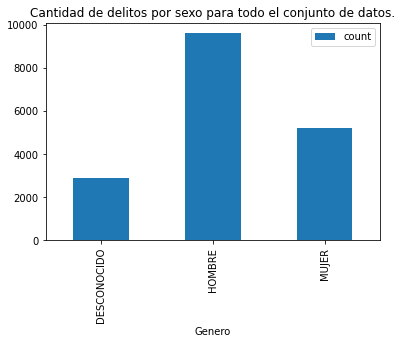

In [235]:
allCrimesByDistric=oijEstadistics.groupBy("Genero","Delito").count().orderBy(desc("count"))
graphic = allCrimesByDistric.toPandas()
graphic.groupby('Genero')['count'].sum().plot(kind='bar',legend=reverse, title='Cantidad de delitos por sexo para todo el conjunto de datos.')

### 5. Proponga una visualización de su interés.

#### 5.a Grafique la cantidad de delitos por victima para todo el conjunto de datos

<AxesSubplot:title={'center':'Cantidad de delitos por victima para todo el conjunto de datos'}, xlabel='Victima'>

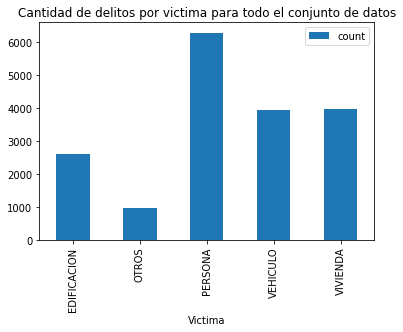

In [236]:
allCrimesByDistric=oijEstadistics.groupBy("Victima","Delito").count().orderBy(desc("count"))
graphic = allCrimesByDistric.toPandas()
graphic.groupby('Victima')['count'].sum().plot(kind='bar',legend=reverse, title = 'Cantidad de delitos por victima para todo el conjunto de datos')